In [3]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

In [4]:
# ! pip install tiktoken
# ! pip install blobfile
# ! pip install torch

In [4]:
with open("Meta-Llama-3-8B//params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

## BPE Tokenization:

In [6]:
tokenizer_path = "Meta-Llama-3-8B//tokenizer.model" ## Taken from Meta Downloaded weights

## Getting the special Tokens from the LLaMA Repo on Github
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]



mergeable_ranks = load_tiktoken_bpe(tokenizer_path) ## Feeding our Tokenizer path into the BPE Tokenizer
#mergeable_ranks is a dictionary-like object that stores the ranks for each pair of subword units. 
#These ranks determine the order in which subword units are merged during the tokenization process. 
#Lower ranks indicate a higher priority for merging.


tokenizer = tiktoken.Encoding(
            name =  Path(tokenizer_path).name,  #takes path to the Tokenizer
            pat_str = r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+", ##regex values to split the tokens
            mergeable_ranks = mergeable_ranks,
            special_tokens = {token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

### Testing out Tokenizer on some input text:

In [73]:
## encode text:
tokenizer.encode("Whenever there is decay of righteousness, O Bharata, And there is exaltation of unrighteousness, then I Myself")

[65361,
 1070,
 374,
 31815,
 315,
 71329,
 11,
 507,
 67692,
 460,
 11,
 1628,
 1070,
 374,
 506,
 3223,
 367,
 315,
 653,
 1315,
 34172,
 2136,
 11,
 1243,
 358,
 3092,
 726]

In [75]:
## decode the tokenized text:
tokenizer.decode(tokenizer.encode("Whenever there is decay of righteousness, O Bharata, And there is exaltation of unrighteousness, then I Myself "))

'Whenever there is decay of righteousness, O Bharata, And there is exaltation of unrighteousness, then I Myself'

## Converting our Tokenized Text into Vectors:

technically these are tensors

In [76]:
text_prompt = " Whenever there is decay of righteousness, O Bharata,And there is exaltation of unrighteousness, then I Myself "

##"<|begin_of_text|>" has a token value of 128000 so we add it to our text prompt
tokens = [128000] + tokenizer.encode(text_prompt)


## We feed this into a pytorch torch.tensor() method to convert into a Vector
tokens = torch.tensor(tokens)


## Let us view how our input text is tokenized:
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

['<|begin_of_text|>', ' Whenever', ' there', ' is', ' decay', ' of', ' righteousness', ',', ' O', ' Bhar', 'ata', ',', 'And', ' there', ' is', ' ex', 'alt', 'ation', ' of', ' un', 'right', 'eous', 'ness', ',', ' then', ' I', ' My', 'self', ' ']


In [77]:
vocab_size = config['vocab_size']
dim = config['dim']
model = torch.load("Meta-Llama-3-8B//consolidated.00.pth")


In [78]:
len(prompt_split_as_tokens)
dim

4096

In [79]:
embedding_layer = torch.nn.Embedding(vocab_size, dim) ## Embedding Layer
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])

## These weights are UNNORMALIZED - we need to use RMS Normalization to Normalize them
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([29, 4096])

### torch.SIze = [19, 4096] - 19 is the number of Tokens of our input text and 4096 is the number od dimensions set by dim

## RMS Normalization:

- We want to keep the Shapes the Same
- Just normalise valued using formula below

-We want to **avoid dividing by 0** so we add a norm_eps value to our calculated RMS

In [80]:
## Create a Function that Normalizes our Embedding vectors

## Small value to be added to RMS's in order to avoid 0 division
norm_eps = config['norm_eps']

def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

In [81]:
## Run the above RMS Normalization Function

### Osberve how shape does not change:

token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([29, 4096])

# Building Multi-Query Attention
 *from scratch of course*

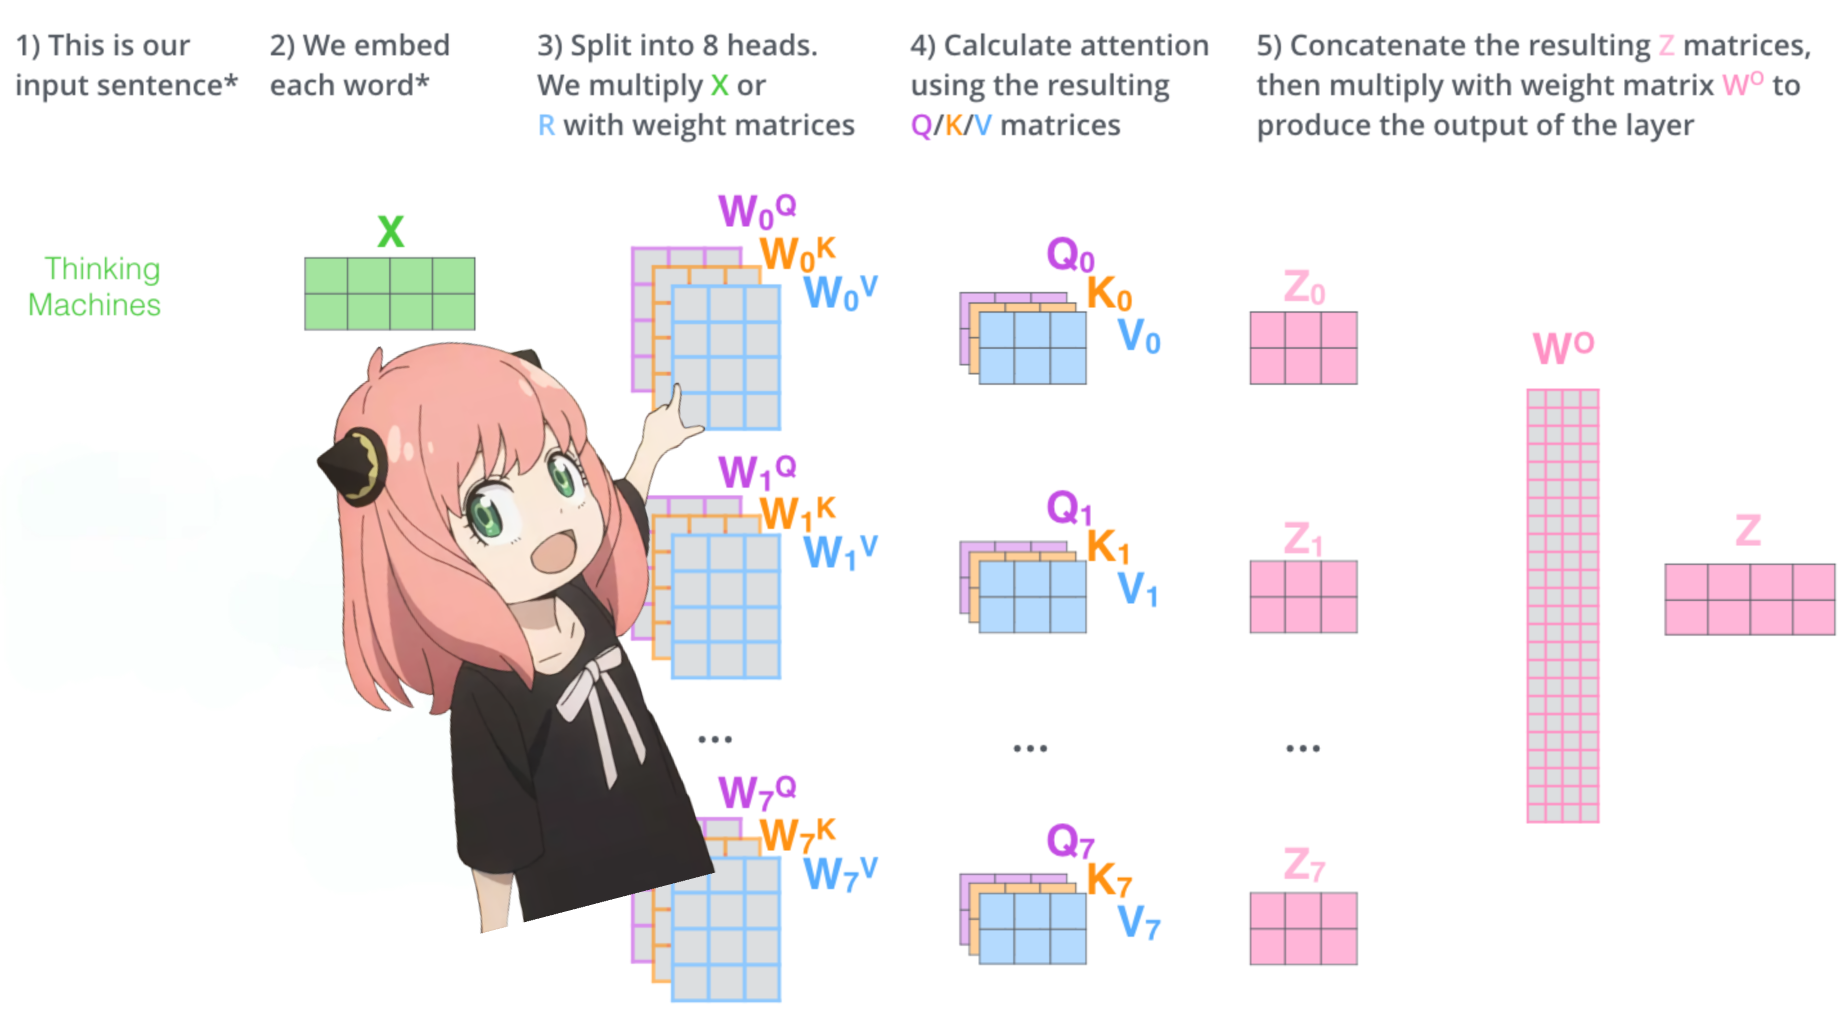

### Loading the Attention-Weight Vectors:

W_q, W_k, W_v, and W_o 

for Query, Keys, Values and Output respectively

In [82]:
print(model["layers.0.attention.wq.weight"].shape)
print(model["layers.0.attention.wk.weight"].shape)
print(model["layers.0.attention.wv.weight"].shape)
print(model["layers.0.attention.wo.weight"].shape)

torch.Size([4096, 4096])
torch.Size([1024, 4096])
torch.Size([1024, 4096])
torch.Size([4096, 4096])


**Shapes of Key and Value Vectors are off:**
--- 4096/4 = 1024

This is because of K-V Cache - i.e to reduce computation time: so K,V share 4 heads at a time

### Query Attention Computation:

**1.1) Splitting into 32 attention-heads:**

In [83]:
n_heads = config['n_heads']

In [84]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

We have 32 'heads' of shape 128 * 4096

Let us now implement 'Attention' on the first 'head':

In [85]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

**Matrix Multiplying our Input-Token Embeddings Matrix with the Q_Head_0 Matrix:**

(19, 4096) * (128, 4096)**T**

= (19, 128)

In [86]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([29, 128])

## **Applying RoPE Postional Encoding**:

**2.2 Spliting the Weighted Tokens into Pairs:**

Each of the 19 tokens' 128-weight vectors are split into 2 pairs of 64 each

We now have 2 vectors of [19,64] each

In [87]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([29, 64, 2])

In [88]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [89]:
rope_theta = config['rope_theta']

freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

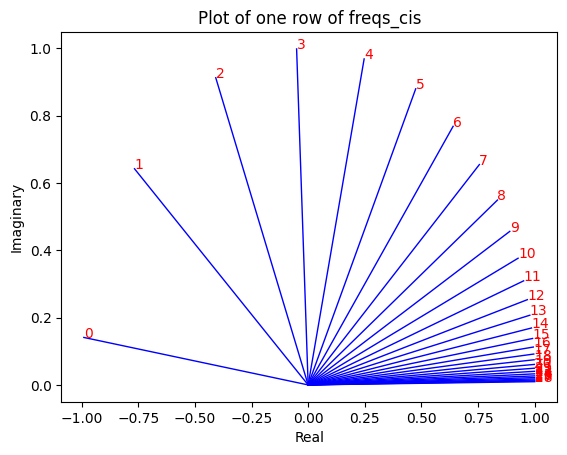

In [90]:
freqs_for_each_token = torch.outer(torch.arange(29), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing the third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:29]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

In [91]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([29, 64])

In [92]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([29, 64])

In [93]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([29, 64, 2])

In [104]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([29, 128])

### Repeat Attention + RoPE Encoding for Keys:

Remember that the  Key and Value weight matrice only have 1024 dimnesions because of K,V Cache

In [105]:

print(model["layers.0.attention.wk.weight"].shape)

torch.Size([1024, 4096])


k,v have fewer heads (4) than q (32) because of Multi-Query Attention

In [106]:
n_kv_heads = config['n_kv_heads']
n_kv_heads

8

In [107]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [108]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

**Matrix Multiplying our Input-Token Embeddings Matrix with the K_Head_0 Matrix:**

(19, 4096) * (128, 4096)**T**

= (19, 128)

In [109]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([29, 128])

Applying RoPE to Key:

In [110]:
## Splitting into Pairs
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

## Convert to Complex Numbers
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

## RoPE Frequencies only need to be calculated once - just feed Key values to Frequencies calculated with Queries
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape


##This is our Rotated Vector:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape


torch.Size([29, 128])

## Multiplying Rotated Q and Rotated K Matrices:

Basically iplement the Attention Softmax() formula:

softmax((Q*KT)/sqrt(dk))*V

In [111]:
## Multiplying Q with transpose of K 

## dividing by Square Root of head_dimensions

qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([29, 29])

**Notice how we have not applied Softmax() yet - Only done the QK/sqrt(d_head)

Why - because we want to MASK the future tokens

## Applying Masks on Future tokens:

We start by creating a Matrix with the top right triangle being -inf 

This way during the softmax process - the attentin values becomes zero:

In [112]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -i

In [113]:
qk_per_token_after_masking = qk_per_token + mask

### **NOW** apply Softmax:

In [114]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)


### Multiplying by VALUES:


Softmax() scores (0-1) are used to determine how much of value matrix is used per token

just like keys, value weights are also shared acorss every 4 attention heads (to save computation)

as a result, the shape of the value weight matrix below is [8x128x4096]



In [115]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

In [116]:
## first of 8 value heads:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

## Each head = 128 * 4096

torch.Size([128, 4096])

In [117]:
## Multiplying the W_v heads with our Token Matrix to get 19*128 matrix

v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape


## This can now be multipled to our softmax values

torch.Size([29, 128])

### Attention:

In [118]:
## We now have Attention for 1st Layer - 1st Head:

qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([29, 128])

## Repeat Attention for all 32 Heads: - Hence MULTI_Head Attention:

jesht loop it

In [119]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads

                                #Tokens * W_q0^T
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
                                #Tokens * W_k0^T
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
                                #Tokens * W_v0^T
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    ## Applying RoPE:
    
    ## For Queries
    ### Step1) Splitting into Pairs
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)

    ### Step2) Convert Each Pair into Complex Numbers
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)

    ### Step3) COnvert into Frequencies - Rotate
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])

    ### Step4) bring back into real nums from complex nums. 
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    ## Repeat RoPE above for Keys
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)


    ## Attention

    ## Multiple Q * K^T
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5

    ## Masking:
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask

    ## Apply Softmax:
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    #qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

## Should be 32 b'coz 32 heads

len(qkv_attention_store)

32

In [120]:
## We have 32 Matrices of 19*128
qkv_attention_store[0].shape

torch.Size([29, 128])

## Concatenate all 32 heads 

128 * 32 = 4096

we now have a the qkv_attention matrix for all 32 heads on the first layer, next im going to merge all attention scores into one large matrix of size [19x4096]
we are almost at the end :)

In [121]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([29, 4096])

### Final Attention Step-  Multiply by Output Weight Matrix:

In [122]:

w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([29, 4096])

### Adding the Attention values to our Token Embeddings:


Study this More, but basically we have the attention for the first layer now. 

Attention needs to be **added** to the intital embeddings,
The attention matrix itself is not what the LLM outputs - the attention gets added to the intial embeddings:

In [123]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([29, 4096])

### Normalization + Feed Forward Networks:


Basically ek baar phir RMS norm karo - study why we need to normalize

In [124]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([29, 4096])

SWiGLU Feed Forward:

Don't fully undderstand the math behind this but jay sri ram:

In [125]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([29, 4096])

## BASICALLY ONE LAYER IS FULLY COMPLETE

Need to do this for 'n' - 32 layers

so 31 more times

JAY MATA DI

In [126]:
final_embedding = token_embeddings_unnormalized
n_layers = config['n_layers']


for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

### 1 Final RMS Norm:

In [127]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([29, 4096])

In [69]:
model["output.weight"].shape

torch.Size([128256, 4096])

In [128]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

In [129]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(128001)

In [130]:
tokenizer.decode([next_token.item()])

'<|end_of_text|>'